In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.integrate import solve_ivp
from IPython.display import HTML

In [9]:
# Initial Coditions:

# Forcing (Voltage) parameters
f0 = 1.0  # Amplitude of the forcing function
w = 0.5  # Angular frequency (rad/s)
c_L = 2.0
c_R = 1.0


# Generate N_p points per N cycles otherwise the plot won't be smooth and it'll look like a donut since it's essentially connecting dots
N = 50 # number of cycles
points_per_cycle = 50 # number of points per cycle
t_eval = np.linspace(0,N*2*np.pi/w, N * points_per_cycle)

# f_t = f0 *np.cos(w*t) 
# Forcing function f(t), which is proportional to the applied Voltage V(t)
f_t = f0 * np.cos(w * t_eval)

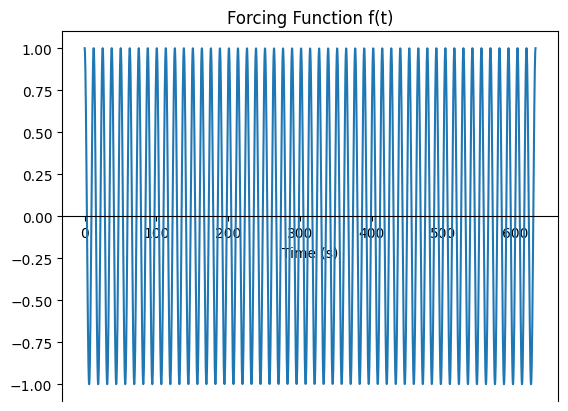

In [10]:
plt.plot(t_eval,f_t)

ax = plt.gca()
plt.title('Forcing Function f(t)')
plt.xlabel('Time (s)')
ax.spines['bottom'].set_position('zero')

## Simple Simple Diffusive Model model with Forcing

In [11]:
def diffusive_ode(t, c, c_L, c_R, f0, w):
    f_t = f0 * np.cos(w * t)
    # This is dc/dt
    return (c_L + c_R)/2 + f_t * (c_L - c_R)/2 - c

c0_diffusive = [(c_L + c_R)/2 + f0 * (c_L - c_R)/2]

# Solve the ODE numerically

sol_diffusive = solve_ivp(
    fun=diffusive_ode,
    t_span=[t_eval[0], t_eval[-1]],
    y0=c0_diffusive,
    args=(c_L, c_R, f0, w),
    t_eval=t_eval,
    dense_output=True
)
c_numerical_diffusive = sol_diffusive.y[0]

# Analytical Solution

def analytical_c_diffusive(t, c_L, c_R, f0, w):
    const_term = (c_L + c_R) / 2
    amp_term = f0 * (c_L - c_R) / 2
    sin_cos_term = (np.cos(w * t) + w * np.sin(w * t)) / (1 + w**2)
    return const_term + amp_term * sin_cos_term

c_analytical_diffusive = analytical_c_diffusive(t_eval, c_L, c_R, f0, w)

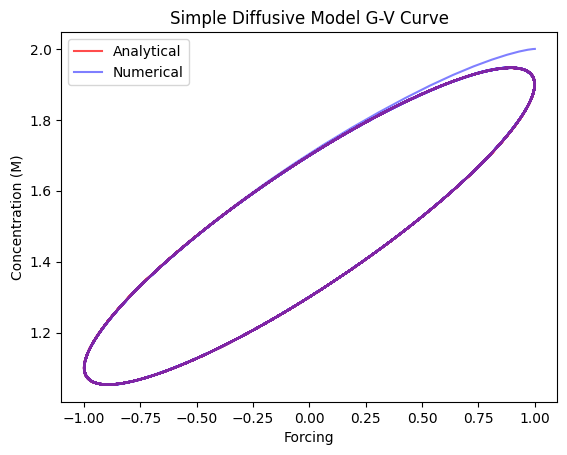

In [12]:
# Plotting the G-V curves for the simplified forced diffusion-advection model

# Plot the analytical solution
plt.plot(f_t, c_analytical_diffusive, 'r-', alpha=0.7)

# Plot the numerical solution

plt.plot(f_t, c_numerical_diffusive, 'b-', alpha=0.5)

plt.title('Simple Diffusive Model G-V Curve')
plt.xlabel('Forcing')
plt.ylabel('Concentration (M)')
plt.legend(['Analytical', 'Numerical'])
plt.show()

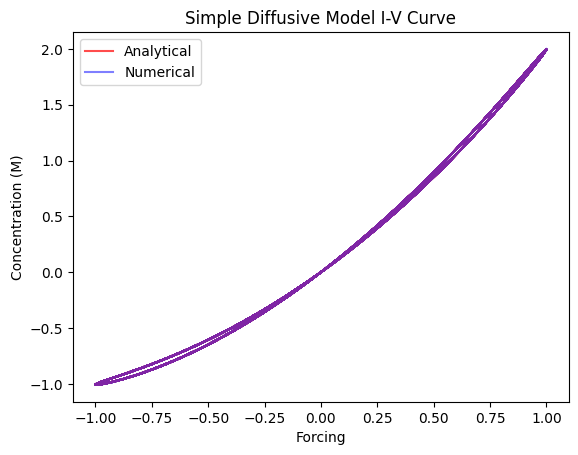

2500 2500 2500


In [8]:
# Plotting the I-V curves for the simplified forced diffusion-advection model

# # Plot the analytical solution
plt.plot(f_t, f_t*c_analytical_diffusive, 'r-', alpha=0.7)

# Plot the numerical solution


plt.plot(f_t, f_t*c_numerical_diffusive, 'b-', alpha=0.5)

plt.title('Simple Diffusive Model I-V Curve')
plt.xlabel('Forcing')
plt.ylabel('Concentration (M)')
plt.legend(['Analytical', 'Numerical'])
plt.show()

print(len(f_t), len(c_numerical_diffusive), len(c_analytical_diffusive))

In [7]:

# Animated plot of diffusive model

fig_diff, ax_diff = plt.subplots()

# Set axis limits based on the complete data range
ax_diff.set_xlim(np.min(f_t)-0.1, np.max(f_t)+0.1)
ax_diff.set_ylim(np.min(c_numerical_diffusive) - 0.2, np.max(c_numerical_diffusive) + 0.2)
ax_diff.set_xlabel('Forcing')
ax_diff.set_ylabel('Concentration')
ax_diff.set_title('Adsorption G-V Curve')
ax_diff.grid(True)

# Initialize two empty line objects: one for numerical, one for analytical
analytical_line, = ax_diff.plot([], [], 'k-', label='Analytical (Steady-State)', alpha=0.5)
numerical_line, = ax_diff.plot([], [], 'b--', label='Numerical', )
ax_diff.legend()


# Rendering takes too long
chunk_size = 1 # Number of new points to add each frame

def update_diffuion(frame_num):
    # Calculate the current index in our data array
    # This will go up in steps of chunk_size
    current_index = frame_num * chunk_size
    
    # Use slicing [:current_index] to trace the curve from the start
    # to the current position.
    numerical_line.set_data(f_t[(current_index-5):current_index], c_numerical_diffusive[(current_index-5):current_index])
    analytical_line.set_data(f_t[:current_index], c_analytical_diffusive[:current_index])
    
    return numerical_line, analytical_line,

# 3. Create and display the animation
# -----------------------------------
# The number of frames is now the total points divided by our chunk size.
# This drastically reduces the frames to render.
num_frames = len(t_eval) // chunk_size



# Create the animation object
# blit=True is a key optimization: it only redraws the parts of the plot that have changed.
animation = FuncAnimation(
    fig=fig_diff,
    func=update_diffuion,
    frames=num_frames,
    interval=100,  # Milliseconds between frames
    blit=True
)

# Display the animation in the notebook
# This is often faster and more convenient than saving to a file for testing.
plt.close(fig_diff) # Prevents a static image from appearing before the animation
HTML(animation.to_jshtml())

## Adsorption-Desorption Simple Diffusive Model Model with Forcing

The minimal model with adsorption and desorption:

\begin{aligned}
\dot{c}+c & =\frac{c_{L}+c_{R}}{2}+f(t) \frac{c_{L}-c_{R}}{2}-k c+\lambda \sigma \\
\dot{\sigma} & =k c-\lambda \sigma
\end{aligned}

can be solved analytically to give:

\begin{aligned}
c(t) & =\frac{c_{L}+c_{R}}{2}+f_{0} \frac{c_{L}-c_{R}}{2} \frac{\left[\lambda^{2}+(1+k) \omega^{2}\right] \cos \omega t+\omega\left[\lambda(k+\lambda)+\omega^{2}\right] \sin \omega t}{\lambda^{2}+\left[(1+k)^{2}+2 k \lambda+\lambda^{2}\right] \omega^{2}+\omega^{4}} \\
\end{aligned}

<br>
<br>

The memory timescale can be calculated by taking the area of the loop which we are given the formula: $$\mathcal{A}(\omega)=\left|\oint\langle c(x, t)\rangle_{x} \mathrm{~d} f\right|=\int_{0}^{2 \pi / \omega} \omega f_{0}\langle c(x, t)\rangle_{x} \sin \omega t \mathrm{~d} t$$


area of the loop is given by the following equation:
$$\mathcal{A}(\omega)=f_{0} \frac{c_{L}-c_{R}}{2} \frac{\omega\left[\lambda(k+\lambda)+\omega^{2}\right]}{\lambda^{2}+\left[(1+k)^{2}+2 k \lambda+\lambda^{2}\right] \omega^{2}+\omega^{4}}$$

In [8]:
# Additional initial parameters

k = 2  # Adsorption rate (k>>1 for strong surface effects)
l = 2 * np.pi # Desorption rate

In [9]:
def adsorp_ode(t, y, c_L, c_R, f0, w, k, l):
    c, sigma = y # Unpacking the coupled equations using a state vector y

    f_t = f0 * np.cos(w * t)
    
    # (Eq. S26) "The rate of change of concentration of" FREE ions
    dcdt = (c_L + c_R)/2 + f_t * (c_L - c_R)/2 - c - k*c + l*sigma
    
    # (Eq. S27) "                                      " ADSORPED ions 
    dsigmadt = k*c - l*sigma
    
    return [dcdt, dsigmadt]

# Initial Conditions

c0_adsorption = (c_L + c_R)/2 + f0 * (c_L - c_R)/2
sigma0_adsorption = (k / l) * c0_adsorption
y0_adsorption = [c0_adsorption, sigma0_adsorption]

# Solve numerically
sol_adsorption = solve_ivp(
    fun=adsorp_ode,
    t_span=[t_eval[0], t_eval[-1]],
    y0=y0_adsorption,
    args=(c_L, c_R, f0, w, k, l),
    t_eval=t_eval,  
    dense_output=True
)

c_numerical_adsorption = sol_adsorption.y[0]
sigma_numerical = sol_adsorption.y[1]

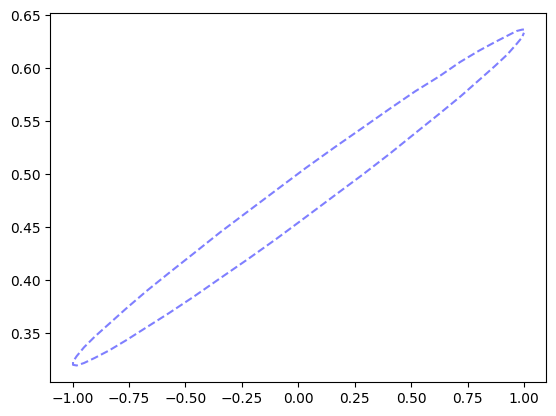

In [10]:
plt.plot(f_t, sigma_numerical, 'b--', alpha=0.5)

In [ ]:
# Analytical Solution

def analytical_c_adsorption(t, c_L, c_R, f0, w, l, k):
    const_term = (c_L + c_R) / 2
    amp_term = f0 * (c_L - c_R) / 2
    sin_cos_term = ((l**2 + (1+k)* w**2)*np.cos(w*t) + w*(l*(k+l)+w**2)*np.sin(w*t)) / (l**2+((1+k)**2 + 2*k*l + l**2)*w**2 + w**4)

    steady_state_solution = const_term + amp_term * sin_cos_term
    return steady_state_solution

c_analytical_adsorption = analytical_c_adsorption(t_eval, c_L, c_R, f0, w, l, k) 


# A_w = (f_0*((c_L + c_R)/2))*[w*(l(k+l) + w**2)]/[l**2+((1+k)**2 + 2*k*l +l**2)*w**2 + w**4]

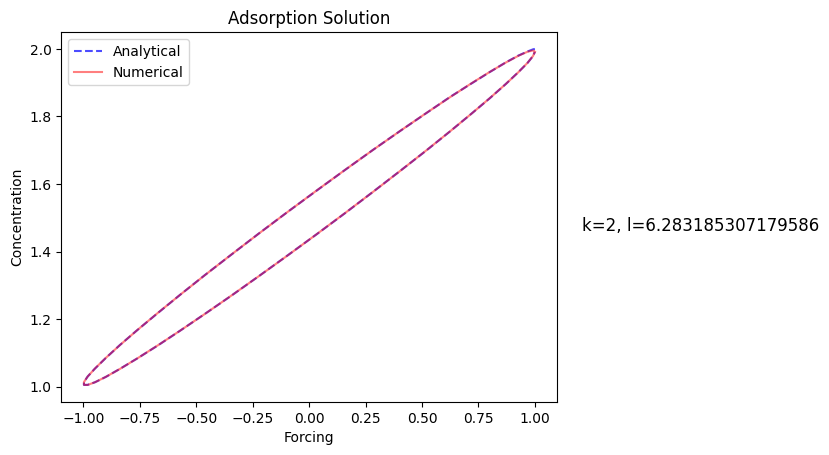

0.1


In [12]:
# Plotting the numerical solution
# NOTE: I've masked over the first few cycles but it represents the transient behaviour


plt.plot(f_t, c_numerical_adsorption, 'b--', alpha=0.7)

# Plotting the analytical solution
plt.plot(f_t, c_analytical_adsorption, 'r-', alpha=0.5)

plt.title('Adsorption Solution')
plt.xlabel('Forcing')
plt.ylabel('Concentration')
plt.legend(['Analytical', 'Numerical'])
plt.text(1.05, 0.5, f'k={k}, l={l}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()
print(w)

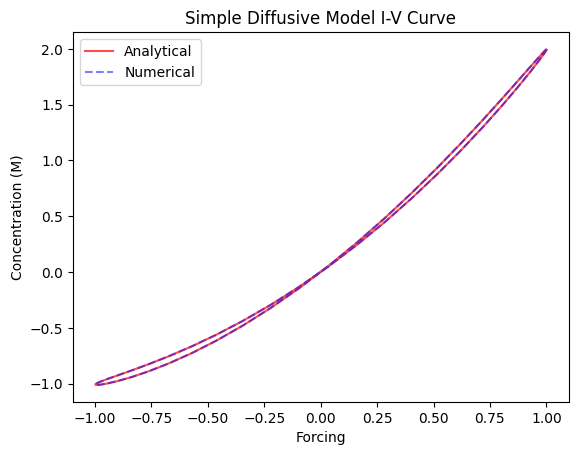

In [13]:
# Plotting the I-V curves for the simplified forced adsorption-desorption model

# Plot the analytical solution
plt.plot(f_t, f_t*c_analytical_adsorption, 'r-', alpha=0.7)

# Plot the numerical solution

plt.plot(f_t, f_t*c_numerical_adsorption, 'b--', alpha=0.5)

plt.title('Simple Diffusive Model I-V Curve')
plt.xlabel('Forcing')
plt.ylabel('Concentration (M)')
plt.legend(['Analytical', 'Numerical'])
plt.show()

In [14]:
# Animated plot of I-V curve for the diffusive model

fig_iv, ax_iv = plt.subplots()

# Set axis limits based on the complete data range
iv_y_numerical = f_t * c_numerical_adsorption
iv_y_analytical = f_t * c_analytical_adsorption
ax_iv.set_xlim(np.min(f_t)-0.1, np.max(f_t)+0.1)
ax_iv.set_ylim(np.min(iv_y_numerical) - 0.2, np.max(iv_y_numerical) + 0.2)
ax_iv.set_xlabel('Forcing')
ax_iv.set_ylabel('Current')
ax_iv.set_title('Simple Diffusive Model I-V Curve')
ax_iv.grid(True)

# Initialize two empty line objects: one for numerical, one for analytical
analytical_line_iv, = ax_iv.plot([], [], 'k-', label='Analytical (Steady-State)', alpha=0.5)
numerical_line_iv, = ax_iv.plot([], [], 'b--', label='Numerical')
ax_iv.legend()

chunk_size = 1  # Number of new points to add each frame

def update_iv(frame_num):
    current_index = frame_num * chunk_size
    numerical_line_iv.set_data(f_t[(current_index-5):current_index], iv_y_numerical[(current_index-5):current_index])
    analytical_line_iv.set_data(f_t[:current_index], iv_y_analytical[:current_index])
    return numerical_line_iv, analytical_line_iv,

num_frames = len(t_eval) // chunk_size

animation_iv = FuncAnimation(
    fig=fig_iv,
    func=update_iv,
    frames=num_frames,
    interval=100,
    blit=True
)

plt.close(fig_iv)
HTML(animation_iv.to_jshtml())

In [ ]:

# Animated plot of adsorption model

fig_adsb, ax_adsb = plt.subplots()

# Set axis limits based on the complete data range
ax_adsb.set_xlim(np.min(f_t)-0.1, np.max(f_t)+0.1)
ax_adsb.set_ylim(np.min(c_numerical_adsorption) - 0.2, np.max(c_analytical_adsorption) + 0.2)
ax_adsb.set_xlabel('Forcing')
ax_adsb.set_ylabel('Concentration')
ax_adsb.grid(True)

# Initialize two empty line objects: one for numerical, one for analytical
analytical_line, = ax_adsb.plot([], [], 'k-', label='Analytical (Steady-State)', alpha=0.5)
numerical_line, = ax_adsb.plot([], [], 'b--', label='Numerical', )
ax_adsb.legend()


# Rendering takes too long
chunk_size = 1 # Number of new points to add each frame

def update_adsorption(frame_num):
    # Calculate the current index in our data array
    # This will go up in steps of chunk_size
    current_index = frame_num * chunk_size
    
    # Use slicing [:current_index] to trace the curve from the start
    # to the current position.
    ax_adsb.set_title('Adsorption G-V Curve, t: {}'.format(current_index))
    numerical_line.set_data(f_t[(current_index-5):current_index], c_numerical_adsorption[(current_index-5):current_index])
    analytical_line.set_data(f_t[:current_index], c_analytical_adsorption[:current_index])
    
    return numerical_line, analytical_line,

# 3. Create and display the animation
# -----------------------------------
# The number of frames is now the total points divided by our chunk size.
# This drastically reduces the frames to render.
num_frames = len(t_eval) // chunk_size



# Create the animation object
# blit=True is a key optimization: it only redraws the parts of the plot that have changed.
animation = FuncAnimation(
    fig=fig_adsb,
    func=update_adsorption,
    frames=num_frames,
    interval=100,  # Milliseconds between frames
    blit=True
)

# Display the animation in the notebook
# This is often faster and more convenient than saving to a file for testing.
plt.close(fig_adsb) # Prevents a static image from appearing before the animation
HTML(animation.to_jshtml())